In [49]:
import sys
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Example trades file
trades = pd.read_csv("tradies.csv")
print(trades.head(5))

   Unnamed: 0                  TIMESTAMP FEEDCODE BUYSELL    PRICE  VOLUME
0           0  2021-01-04 03:02:00+00:00    HHIF1       S  10672.0    15.0
1           1  2021-01-04 03:02:00+00:00    HSIF1       B  27342.0     2.0
2           2  2021-01-04 03:03:00+00:00    HHIF1       S  10673.0     8.0
3           3  2021-01-04 03:03:00+00:00    HSIF1       B  27348.0     2.0
4           4  2021-01-04 03:04:00+00:00    HHIF1       S  10671.0    12.0


In [ ]:
trades = trades.loc[:, ~trades.columns.str.contains('^Unnamed')]


In [54]:
# Check the columns in the trades DataFrame
print(trades.columns)

# Preview the first few rows
print(trades.head())


Index(['TIMESTAMP', 'FEEDCODE', 'BUYSELL', 'PRICE', 'VOLUME'], dtype='object')
                   TIMESTAMP FEEDCODE BUYSELL    PRICE  VOLUME
0  2021-01-04 03:02:00+00:00    HHIF1       S  10672.0    15.0
1  2021-01-04 03:02:00+00:00    HSIF1       B  27342.0     2.0
2  2021-01-04 03:03:00+00:00    HHIF1       S  10673.0     8.0
3  2021-01-04 03:03:00+00:00    HSIF1       B  27348.0     2.0
4  2021-01-04 03:04:00+00:00    HHIF1       S  10671.0    12.0


In [57]:

# Convert the timestamp column to UTC if it is already timezone-aware
trades['TIMESTAMP'] = pd.to_datetime(trades['TIMESTAMP']).dt.tz_convert('UTC')


In [63]:
trades.iloc[0].TIMESTAMP

Timestamp('2021-01-04 03:02:00+0000', tz='UTC')

In [64]:
trades

,TIMESTAMP,FEEDCODE,BUYSELL,PRICE,VOLUME
0,2021-01-04 03:02:00+00:00,HHIF1,S,10672.0,15.0
1,2021-01-04 03:02:00+00:00,HSIF1,B,27342.0,2.0
2,2021-01-04 03:03:00+00:00,HHIF1,S,10673.0,8.0
3,2021-01-04 03:03:00+00:00,HSIF1,B,27348.0,2.0
4,2021-01-04 03:04:00+00:00,HHIF1,S,10671.0,12.0
...,...,...,...,...,...
1365227,2023-12-29 18:58:00+00:00,HSIF4,S,17158.0,4.0
1365228,2023-12-29 18:59:00+00:00,HHIF4,S,5814.0,15.0
1365229,2023-12-29 18:59:00+00:00,HSIF4,B,17156.0,1.0
1365230,2023-12-29 19:00:00+00:00,HHIF4,S,5814.0,3.0


### BACKTESTING @ Jeffrey Tan

In [67]:
import sys, os
import datetime as dt
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from pandas.io.formats.style import Styler


TEN_THOUSAND = 10_000
ONE_MILLION = 1_000_000

def make_trades_time_aware(trades):
    
    
    return trades
    
    
def safe_divide(lhs: Union[np.ndarray, float], rhs: Union[np.ndarray, float], fill_value: float = 0.0) -> np.ndarray:
    out = np.full(np.broadcast(lhs, rhs).shape, fill_value=float(fill_value))
    return np.divide(lhs, rhs, out=out, where=rhs != 0)

def drawdown_stats(x):
    try:
        x_cum = x.cumsum()
        high_water = x_cum.expanding().max().bfill()  # Updated by @1ssb
        under_water = x_cum - high_water
        drawdown = min(0, under_water.min())
        days_under_water = high_water.expanding().apply(lambda x: len(x) - 1 - np.argmax(np.ma.masked_invalid(x)))
        max_underwater_duration = np.max(days_under_water)

        end_high_water_period = ((days_under_water == 0) * 1).cumsum()

        dd_input = pd.DataFrame(
            {
                "end_high_water_period": end_high_water_period,
                "under_water": under_water,
                "days_under_water": days_under_water,
            }
        )

        def calculate_dd_duration(x):
            i = x.under_water.idxmin()
            return x.loc[i].days_under_water

        # drawdown_duration = calculate_dd_duration(dd_input)
        dd_dur = dd_input.groupby("end_high_water_period", include_groups=False).apply(calculate_dd_duration) # Updated by @1ssb
        max_drawdown_duration = dd_dur.max()

        dds = dd_input.groupby(end_high_water_period)["under_water"].min()
        dds = dds.sort_values()
        dds = dds[dds < 0]
        if dds.shape[0] > 5:
            dds = dds.iloc[:5]
        drawdown_conservative = dds.mean() * 1.5

        return drawdown, max_underwater_duration, max_drawdown_duration, drawdown_conservative
    except:
        return 0, 0, 0, 0

def calculate_execution_top_mode(trades: pd.DataFrame, bid_price: pd.DataFrame, ask_price) -> pd.DataFrame:
    exprice = pd.DataFrame(np.zeros(bid_price.shape), index=bid_price.index, columns=bid_price.columns)
    exprice[trades > 0] = ask_price[trades > 0]
    exprice[trades < 0] = bid_price[trades < 0]
    return exprice

def feedcode_to_und(fc: str):
    if fc.startswith("HHI"):
        return 50.0
    elif fc.startswith("HSI"):
        return 50.0
    elif fc.startswith("CN"):
        return 1.0
    raise

def fx_from_fc(fc: str):
    if fc.startswith("HHI"):
        return 1.0  # HKD
    elif fc.startswith("HSI"):
        return 1.0  # HKD
    elif fc.startswith("CN"):
        return 7.81  # USD to HKD
    raise

def display_result(df: pd.DataFrame) -> Styler:
    fixed_column_width = "75px"
    heading_color = "#eee"

    table_styles = [
        dict(selector="tr:hover", props=[("background", "#f4f4f4")]),
        dict(
            selector="th",
            props=[
                ("background", heading_color),
                ("border", "1px solid #eee"),
                ("border-collapse", "collapse"),
            ],
        ),
        dict(
            selector="td",
            props=[
                ("border", "1px solid #eee"),
                ("border-collapse", "collapse"),
            ],
        ),
        dict(
            selector=".row_heading",
            props=[
                ("text-align", "right"),
                ("min-width", fixed_column_width),
            ],
        ),
        dict(
            selector="table",
            props=[
                ("margin", "25px auto"),
                ("border-collapse", "collapse"),
                ("border", "1px solid #eee"),
                ("border-bottom", "2px solid #00cccc"),
            ],
        ),
    ]
    styles = table_styles + [dict(selector=f".col{i}", props=[("min-width", fixed_column_width)]) for i in range(len(df.columns))]

    return df.style.format("{:.2f}").set_table_styles(styles)

def _get_ref_prices():
    price = pd.read_parquet(r"results\data\ref_prices.parquet")
    bid_price = pd.read_parquet(r"results\data\bid_prices.parquet")
    ask_price = pd.read_parquet(r"results\data\ask_prices.parquet")

    price = price.ffill()
    bid_price = bid_price.ffill()
    ask_price = ask_price.ffill()

    return price, bid_price, ask_price

def convert_trades_df(trades: pd.DataFrame):
    """Convert a user-provided trades dataframe to the format the tearsheet code expects."""
    expected_cols = ["TIMESTAMP", "BUYSELL", "VOLUME", "FEEDCODE"]
    for c in expected_cols:
        assert c in trades.columns, f"Missing column {c} in trades dataframe."

    trades["VOLUME_SIGNED"] = np.where(trades["BUYSELL"] == "B", trades["VOLUME"], -trades["VOLUME"])
    trades = trades.set_index("TIMESTAMP")
    trades = trades.sort_index(ascending=True)

    try:
        trades = trades.tz_convert("Asia/Hong_Kong")
    except:
        raise ValueError("Cannot convert trades dataframe to Asia/Hong_Kong. The TIMESTAMP entries must be tz-aware.")

    assert trades.groupby([trades.index, "FEEDCODE"])["BUYSELL"].count().max() == 1, "More than one instance of a feedcode on a single timeslice."
    trades = trades.pivot(columns="FEEDCODE", values="VOLUME_SIGNED")

    return trades

def calculate_results(trades: pd.DataFrame):
    price, bid_price, ask_price = _get_ref_prices()
    assert trades["VOLUME"].min() > 0, "All volumes provided in the VOLUME column must be > 0 (positive)."
    trades = convert_trades_df(trades)
    assert trades.index.tz.zone == "Asia/Hong_Kong"
    trades = trades.reindex(price.index).fillna(0)
    pos = trades.cumsum()
    
    exprice = calculate_execution_top_mode(trades, bid_price, ask_price)
    snap_date = trades.index.date
    multiplier = pd.Series({fc: feedcode_to_und(fc) for fc in price.columns})
    fx = pd.Series({fc: fx_from_fc(fc) for fc in multiplier.index})
    
    turnover = (trades * exprice * multiplier * fx).abs().iloc[:, :].sum(axis=1) / ONE_MILLION
    
    cash = ((-(trades * exprice) * multiplier * fx).sum(axis=1)) / ONE_MILLION
    cash_midpoint = ((-(trades * price) * multiplier * fx).sum(axis=1)) / ONE_MILLION
    
    turnover = turnover.groupby(snap_date).sum()
    cash_daily = cash.groupby(snap_date).sum()
    cash_midpoint_daily = cash_midpoint.groupby(snap_date).sum()
    
    cash_delta = pos * price * multiplier * fx / ONE_MILLION
    cash_delta_daily = cash_delta.groupby(snap_date).last()
    
    pnl = cash_daily.cumsum() + cash_delta_daily.sum(axis=1)
    midpoint_pnl = cash_midpoint_daily.cumsum() + cash_delta_daily.sum(axis=1)
    daily_pnl = pnl.diff()
    daily_pnl.iloc[0] = pnl.iloc[0]
    midpoint_daily_pnl = midpoint_pnl.diff()
    midpoint_daily_pnl.iloc[0] = midpoint_pnl.iloc[0]

    daily_pnl_no_weekends = daily_pnl[[x.weekday() not in [5, 6] for x in daily_pnl.index]]
    sharpe = daily_pnl.mean() / daily_pnl.std() * np.sqrt(261)
    drawdown, max_underwater_duration, max_drawdown_duration, drawdown_conservative = drawdown_stats(daily_pnl)
    
    result = pd.DataFrame(
        {
            "NumDays": (int)(len(pnl)),
            "TotRet$M": pnl.iloc[-1],
            "DailyRet$K": 1e3 * daily_pnl.mean(),
            "Sharpe": sharpe,
            "PnlBps": pnl.iloc[-1] / turnover.sum() * TEN_THOUSAND,
            "ADV$M": turnover.sum() / len(pnl),
            "%Pos": (100 * float((daily_pnl > 0).sum()) / daily_pnl.count()).round(2),
            "WorstDay$M": min(daily_pnl),
            "Std": np.std(daily_pnl),
            "Dd$M": drawdown,
            "MaxUwDu": (int)(max_underwater_duration),
            "MaxDdDu": (int)(max_drawdown_duration),
        }, index=[0],
    )

    return daily_pnl, midpoint_daily_pnl, result

### Start Compute

In [68]:
daily_pnl, midpoint_daily_pnl, result = calculate_results(trades)

,NumDays,TotRet$M,DailyRet$K,Sharpe,PnlBps,ADV$M,%Pos,WorstDay$M,Std,Dd$M,MaxUwDu,MaxDdDu
0,1096.00,-920.91,-840.25,-0.32,-1.69,4960.01,38.14,-788.77,42.19,0.00,0.00,0.00


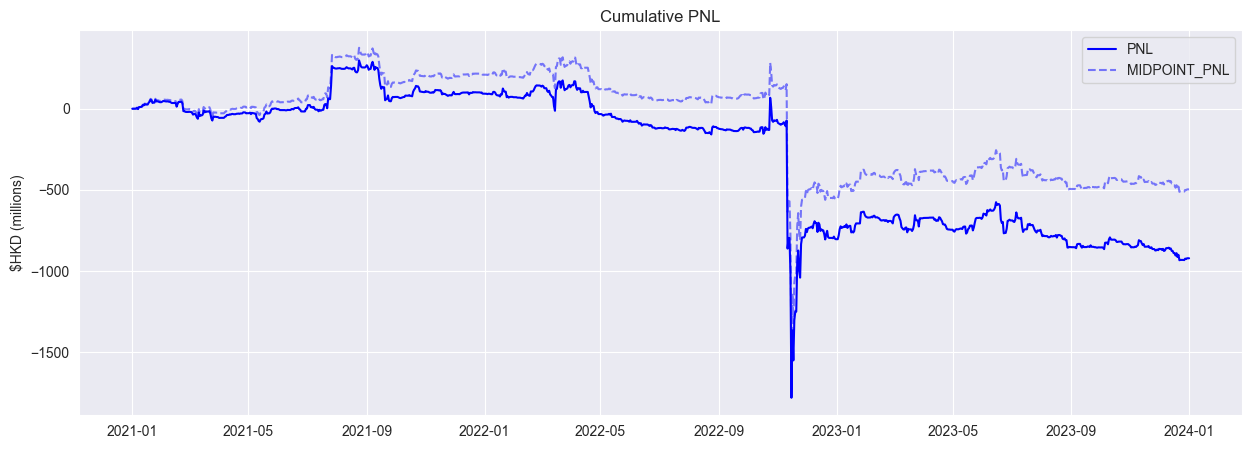

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(daily_pnl.cumsum(), c="blue", label="PNL")
sns.lineplot(midpoint_daily_pnl.cumsum(), c="blue", linestyle="--", alpha=.5, label="MIDPOINT_PNL")
ax.grid(True);
ax.set_ylabel("$HKD (millions)")
ax.set_title("Cumulative PNL")

display_result(result)

<Axes: >

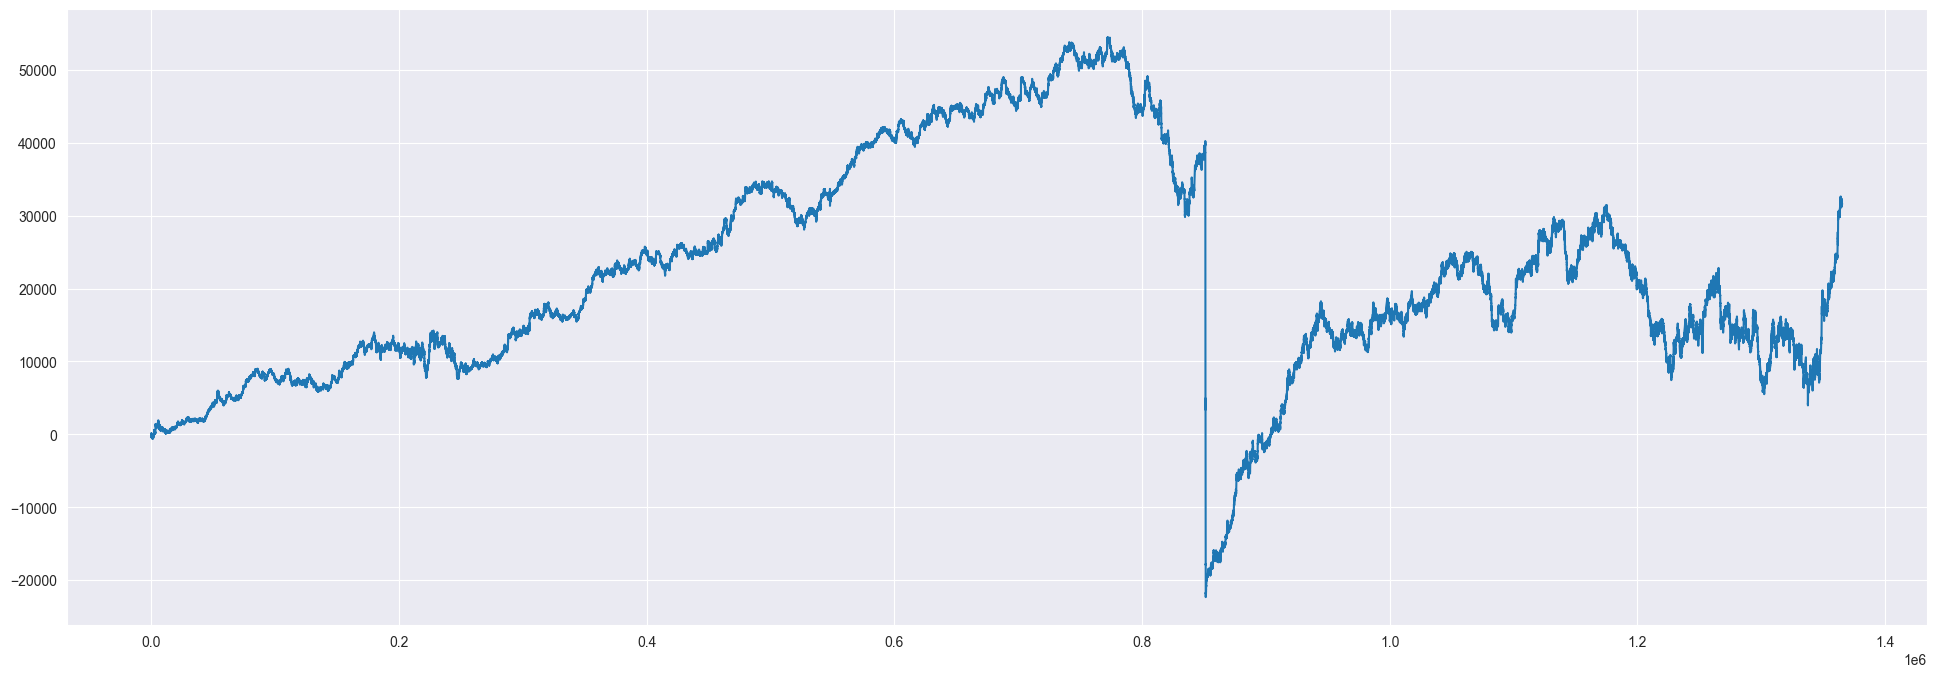

In [70]:
fig, ax = plt.subplots(figsize=(24, 8))
copy = trades.copy()
copy.set_index("TIMESTAMP")
copy["VOLUME_SIGNED"].cumsum().plot(ax=ax)